# Twitter Analysis
In this notebook, we will be conducting a Twitter data analysis on the perspective people have on CalFresh / SNAP. Since we discovered that the two states with the lowest and highest usage of SNAP were Wyoming and Oregon, we decided to take a deeper look into the largest cities in each state. By scraping data from Twitter, we created word clouds and sentiment analysis charts to understand the perspective that people have towards food stamps / SNAP. 

In [1]:
# the regulars
import pandas as pd
import numpy as np
import plotly.express as px
import osmnx as ox
import matplotlib.pyplot as plt

# to get tweets
import tweepy as tw

# for sentiment analysis
from textblob import TextBlob
import re

# word clouds
from wordcloud import WordCloud, STOPWORDS

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Twitter Keys
For this notebook, we will be using Ethan's set of twitter keys for authentication.

In [2]:
consumer_key= 'A0OqUkDl2C5pRzdGuzCQVV2rz'
consumer_secret= 'hlOBY1NrvS9fHioutdNwdQYcr8hrjf17kWEkTcTiag0kDOzgVM'
access_token= '2451799802-lJnmy2Bc4RSEHGhjhf0jc6WJn0cuevMtUn2RsZb'
access_token_secret= 'neEJsLVlMVE9e7iiRLjnjzLcnyxcszg2s9dqoLgEALtHT'

In [3]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [51]:
searchterm = 'ebt'

In [57]:
def find_tweets(q,place,distance='5000km',count=50000):
    
    #
    # geocode the place to get coordinates
    #
    
    g = ox.geocoder.geocode(place)
    
    # concatenate the results
    geocode = '"'+str(g[0])+','+str(g[1])+','+distance+'"'
    
    #
    # grab the tweets
    #
    
    tweets = tw.Cursor(api.search,
                       q=q+' -filter:retweets', # no retweets
                       geocode=geocode, 
                       tweet_mode='extended').items(count)
    #
    # create a dataframe
    #
    
    json_data = [tweet._json for tweet in tweets]
    df = pd.json_normalize(json_data)


    # clean the text
    df['clean_text'] = ''
   
    def clean_tweet(tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", tweet).split())
    
    
    for i, row in df.iterrows():
        clean = clean_tweet(row.full_text)
        df.at[i,'clean_text'] = clean

    #
    # word cloud
    #
    
    # put every tweet in a single variable
    all_text = ' '.join(df['clean_text'])
    
    # Create stop words
    stop=list(STOPWORDS)
    stop.append('card')
    stop_words = [searchterm] + list(stop)
    
    # create the word cloud


    wordcloud = WordCloud(width=1200, 
                          height=800,
                          background_color="white",
                          stopwords=stop_words).generate(all_text)

    # Display the WordCloud                    
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    #
    # sentiment analysis
    #
   
    sentiment_colors = ox.plot.get_colors(5,cmap='PiYG',return_hex=True)
    df['polarity']=''
    
    # add polarity index to each tweet
    for i, row in df.iterrows():
        a = TextBlob(row.full_text)
        df.at[i,'polarity'] = a.polarity
    
    # create a list of our conditions
    conditions = [
        (df['polarity'] < -0.2), # very negative
        (df['polarity'] < 0) & (df['polarity'] >= -0.2),   # negative
        (df['polarity'] == 0),  # neutral
        (df['polarity'] > 0) & (df['polarity'] <= 0.2),    # positive
        (df['polarity'] > 0.2)  # very positive
        ]

    # create a list of the values we want to assign for each condition
    values = [
        'very negative', 
        'negative', 
        'neutral', 
        'positive',
        'very positive'
        ]

    # create a new column and use np.select to assign values to it using our lists as arguments
    df['sentiment'] = np.select(conditions, values)

    #
    # Sentiment bar chart
    #
    
    # bar chart
    fig = px.bar(df, 
                 x='sentiment',
                 width=600,
                 title='Sentiment analysis for "'+ q + '"',
                 color='sentiment',
                 category_orders = {'sentiment':['very negative','negative','neutral','positive','very positive']},
                 color_discrete_sequence=sentiment_colors, # use the colors selected in previous cell
                )
    # fig.update_traces(textinfo='value')
    fig.update_traces(marker_line_width=0) # gets rid of horizontal white lines
    fig.show()

    #
    # histogram
    # 
    
    num_bins = 50
    plt.figure(figsize=(10,6))
    n, bins, patches = plt.hist(df.polarity, num_bins, facecolor='blue', alpha=0.5)
    plt.xlabel('Polarity')
    plt.ylabel('Count')
    plt.title('Histogram of polarity for "' + q + '"')

    plt.axvline(df.polarity.mean(), color='k', linestyle='dashed', linewidth=1)

    min_ylim, max_ylim = plt.ylim()
    plt.text(df.polarity.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df.polarity.mean()))

    plt.show()


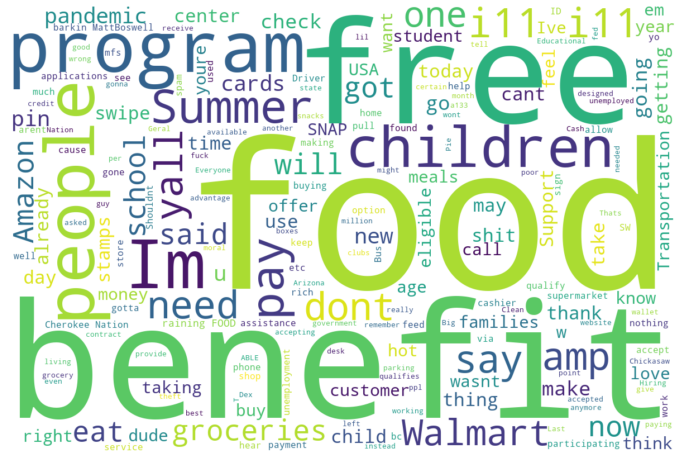

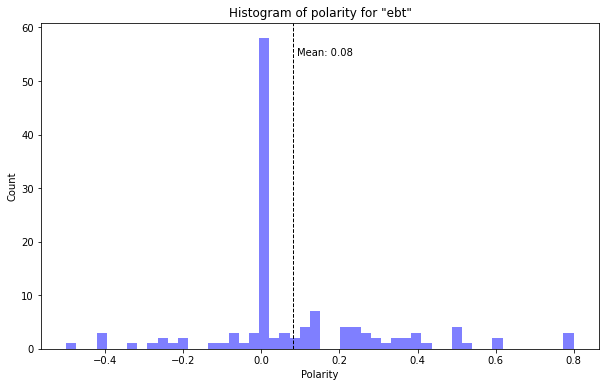

In [58]:
find_tweets(q='ebt',place='82001')

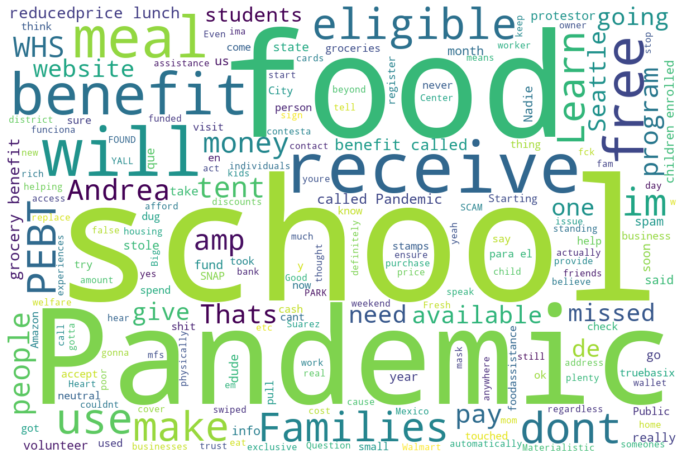

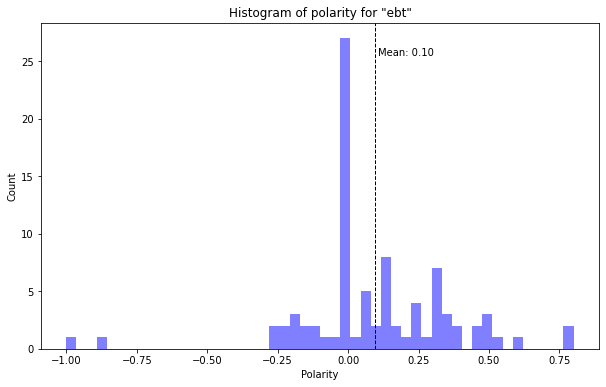

In [59]:
find_tweets(q='ebt',place='97229')